In [1]:
# ------Import standard libraries------
import math
import cv2
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
#from scipy.fft import fft
from numpy.fft import fft

# import the cv2_imshow function  from patches to use in Google Collab
# import functions from the scipy.signal module for signal processing
from scipy.signal import butter, filtfilt, find_peaks
import scipy.signal as signal
#import and mount the drive module to access files and directories from Google Drive
import pandas as pd
import os

In [ ]:
directorio = os.getcwd()
subdirectorio = "HRV"
subcarpeta_rostro = "Base de Datos Procesados"
archivo = "003_dedo.mp4"
ruta_video = str(os.path.join(directorio, subdirectorio,subcarpeta_rostro, archivo))
csv_file = str(os.path.join(directorio, subdirectorio,subcarpeta_rostro, archivo.replace(".mp4",".csv")))
print(ruta_video)
print(csv_file)

In [5]:
def obtener_rutas(numero_video, es_dedo):
    directorio = os.getcwd()
    subdirectorio = "DB"
    
    # Determinar el nombre del archivo en base a si es dedo o no
    if es_dedo:
        nombre_archivo = f"{numero_video}_dedo.mp4"
    else:
        nombre_archivo = f"{numero_video}.mp4"
    
    # Construir la ruta completa para el video
    ruta_video = os.path.join(directorio, subdirectorio, nombre_archivo)
    
    # Construir la ruta completa para el archivo CSV correspondiente
    csv_file = os.path.join(directorio, subdirectorio, f"{numero_video}.csv")
    
    # Imprimir las rutas
    print("Ruta del video:", ruta_video)
    print("Ruta del archivo CSV:", csv_file)

    return ruta_video, csv_file


In [21]:
numero_video = "007"
es_dedo = True  # Cambiar a False si no es un video de tipo 'dedo'

ruta_video, csv_file = obtener_rutas(numero_video, es_dedo)

Ruta del video: c:\Users\juanv\Documents\HRV_Analysis\DB\007_dedo.mp4
Ruta del archivo CSV: c:\Users\juanv\Documents\HRV_Analysis\DB\007.csv


In [22]:
import cv2
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt
# Carga el clasificador Haarcascade preentrenado para detección de caras
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Carga el video desde tu computadora a Google Colab
video_filename = ruta_video
# Abre el video
cap = cv2.VideoCapture(video_filename)
fps = cap.get(cv2.CAP_PROP_FPS)
fs = round(fps)
print("Frames per second:",fs)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("Frame count:",frame_count) #Full video

Frames per second: 30
Frame count: 17730


In [ ]:
#Para video de rostro
saturation_values = []  # Lista para almacenar los valores de saturación
hue_values = []  # Lista para almacenar los valores de tono
# Leer el video fotograma a fotograma
while True:
    ret, frame = cap.read()
    if not ret:
        break  # Salir del bucle si no quedan más fotogramas

    # Convertir a escala de grises para la detección de rostros
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detectar rostros
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) > 0:
        # Tomar el primer rostro detectado
        x, y, w, h = faces[0]

        # Definir una ROI para el rostro entero
        roi = frame[y:y+h, x:x+w]

        # Convertir la ROI a HSV
        hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
        h, s, v = cv2.split(hsv_roi)

        # Calcular la intensidad promedio del canal de saturación en la ROI
        saturation_values.append(np.mean(h))

        # Calcular la intensidad promedio del canal de tono en la ROI
        hue_values.append(np.mean(s))

# Convertir la lista de valores de saturación a un array de numpy
saturation_array = np.array(saturation_values)
# Convertir la lista de valores de tono a un array de numpy
hue_array = np.array(hue_values)

In [23]:
#Para video de dedo
saturation_values = []  # Lista para almacenar los valores de saturación
hue_values = []  # Lista para almacenar los valores de tono

# Leer el video fotograma a fotograma
while True:
    ret, frame = cap.read()
    if not ret:
        break  # Salir del bucle si no quedan más fotogramas

    # Convertir el fotograma completo a HSV
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Extraer el canal de saturación
    h, s , _ = cv2.split(hsv_frame)

    # Calcular la intensidad promedio del canal de saturación en el fotograma completo
    saturation_values.append(np.mean(s))
    # Calcular la intensidad promedio del canal de tono en el fotograma completo
    hue_values.append(np.mean(h))


# Convertir la lista de valores de saturación a un array de numpy
saturation_array = np.array(saturation_values)
# Convertir la lista de valores de tono a un array de numpy
hue_array = np.array(hue_values)



In [24]:

# Aplicar un filtro pasa banda para obtener la señal del pulso
lowcut = 1.0
highcut = 1.6

# Función para crear un filtro pasa banda Butterworth
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Función para aplicar el filtro
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filtrar la señal
filtered_saturation = butter_bandpass_filter(saturation_array, lowcut, highcut, fs, order=5)
filtered_hue = butter_bandpass_filter(hue_array, lowcut, highcut, fs, order=5)
# Realizar FFT en la señal filtrada
saturation_fft = fft(filtered_saturation)
hue_fft = fft(filtered_hue)

# Calcular las frecuencias correspondientes
freqs_saturation = np.fft.fftfreq(len(filtered_saturation), 1/fs)
freqs_hue = np.fft.fftfreq(len(filtered_hue), 1/fs)

# Encuentra la frecuencia con la magnitud más alta en el rango de la frecuencia cardíaca
idx_saturation = np.argmax(np.abs(saturation_fft))
pulse_freq_saturation = freqs_saturation[idx_saturation]
heart_rate_saturation = pulse_freq_saturation * 60  # Convertir a latidos por minuto

idx_hue = np.argmax(np.abs(hue_fft))
pulse_freq_hue = freqs_hue[idx_hue]
heart_rate_hue = pulse_freq_hue * 60  # Convertir a latidos por minuto



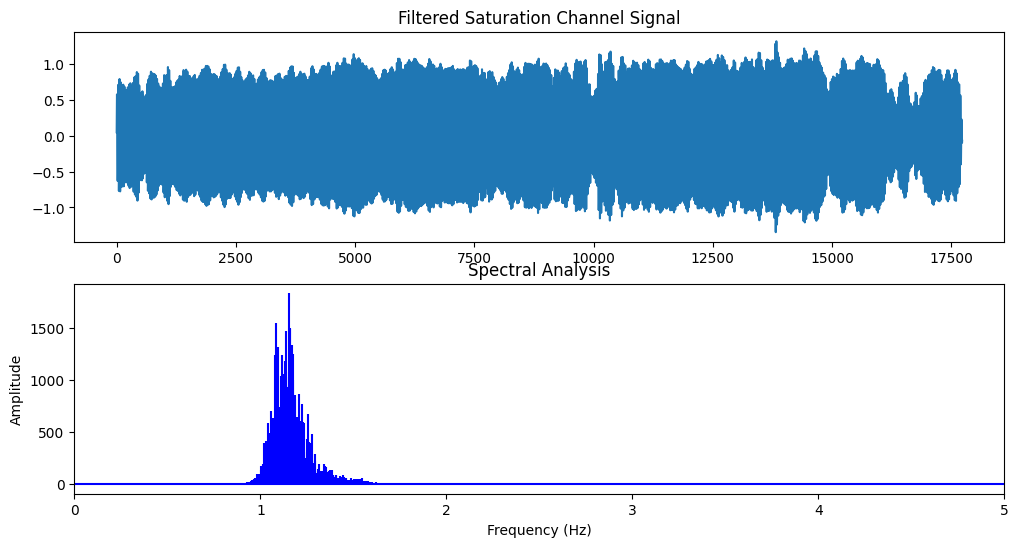

Estimated Heart Rate in Saturation: -69.2 beats per minute


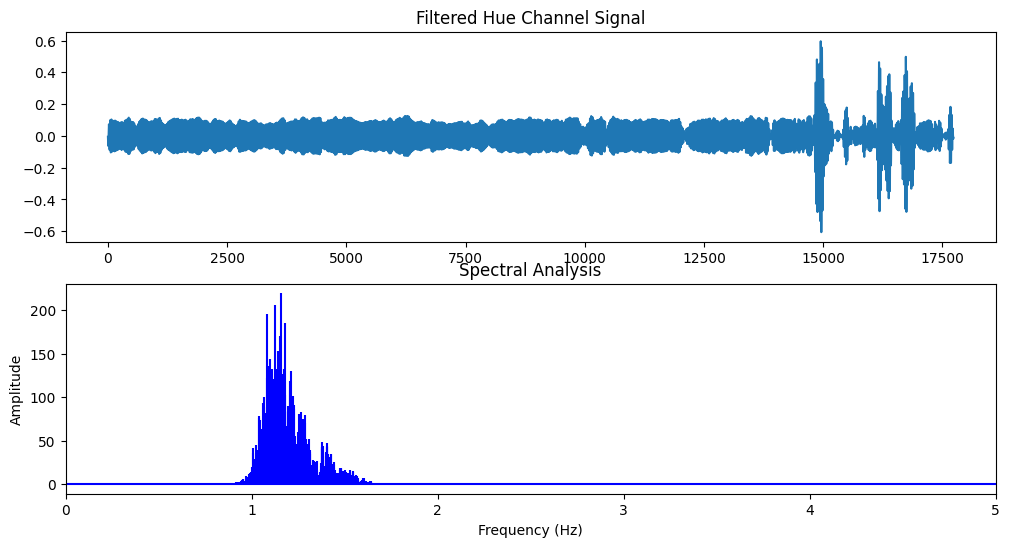

Estimated Heart Rate in Hue: 69.5 beats per minute


In [25]:

# Mostrar los resultados de saturacion
plt.figure(figsize=(12, 6))

# Mostrar la señal temporal filtrada
plt.subplot(2, 1, 1)
plt.plot(filtered_saturation)
plt.title('Filtered Saturation Channel Signal')

# Mostrar el espectro de la señal en saturación
plt.subplot(2, 1, 2)
plt.stem(freqs_saturation, np.abs(saturation_fft), 'b', markerfmt=" ", basefmt="-b")
plt.title('Spectral Analysis')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 5)  # Limitar el eje x al rango de interés para la frecuencia cardíaca
plt.show()

print(f'Estimated Heart Rate in Saturation: {heart_rate_saturation:.1f} beats per minute')

# Mostrar los resultados de tono
plt.figure(figsize=(12, 6))

# Mostrar la señal temporal filtrada
plt.subplot(2, 1, 1)
plt.plot(filtered_hue)
plt.title('Filtered Hue Channel Signal')

# Mostrar el espectro de la señal en tono
plt.subplot(2, 1, 2)
plt.stem(freqs_hue, np.abs(hue_fft), 'b', markerfmt=" ", basefmt="-b")
plt.title('Spectral Analysis')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 5)  # Limitar el eje x al rango de interés para la frecuencia cardíaca
plt.show()

print(f'Estimated Heart Rate in Hue: {heart_rate_hue:.1f} beats per minute')

# Libera el capturador de video
cap.release()

In [26]:
#------Compare to the heart rate calculated from pulse oximeter measurements------

# import the pulse oximeter .csv file
data_video= pd.read_csv(csv_file)

# extract the data from the PULSE column
pulse_signal = data_video['PULSE']

# Take only the numerical values of the signal
pulse_signal = pd.to_numeric(pulse_signal, errors='coerce')
#pulse_signal = pulse_signal[1:703]

# print the size of the signal
print("Signal size:", pulse_signal.size)

# calculate and print the average value of the Heart Rate
heart_rate_csv = np.mean(pulse_signal)
print("\nHeart rate: {:.2f} bpm".format(heart_rate_csv))

# calculate and print the error
error_saturation=abs(heart_rate_saturation-heart_rate_csv)
print("\nError saturación: {:.2f} bpm".format(error_saturation))

error_hue=abs(heart_rate_hue-heart_rate_csv)
print("\nError tono: {:.2f} bpm".format(error_hue))

Signal size: 672

Heart rate: 68.95 bpm

Error saturación: 138.19 bpm

Error tono: 0.59 bpm
